<a href="https://colab.research.google.com/github/PratiekSonare/WiDS-Submissions-Pratiek/blob/main/SeriesForecasting_22B2440.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install pandas-ta

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pandas-ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218907 sha256=433945611e708900f129bba606e1a48f4f9010b5ee581f2afb21c1c55ad4fdf3
  Stored in directory: /root/.cache/pip/wheels/69/00/ac/f7fa862c34b0e2ef320175100c233377b4c558944f12474cf0
Successfully built pandas-ta


[*********************100%%**********************]  1 of 1 completed


Epoch 1/25
61/61 [==============================] - 9s 15ms/step - loss: 0.0193
Epoch 2/25
61/61 [==============================] - 1s 13ms/step - loss: 0.0118
Epoch 3/25
61/61 [==============================] - 1s 13ms/step - loss: 0.0109
Epoch 4/25
61/61 [==============================] - 1s 15ms/step - loss: 0.0095
Epoch 5/25
61/61 [==============================] - 1s 16ms/step - loss: 0.0095
Epoch 6/25
61/61 [==============================] - 1s 15ms/step - loss: 0.0088
Epoch 7/25
61/61 [==============================] - 1s 13ms/step - loss: 0.0092
Epoch 8/25
61/61 [==============================] - 1s 13ms/step - loss: 0.0078
Epoch 9/25
61/61 [==============================] - 1s 13ms/step - loss: 0.0068
Epoch 10/25
61/61 [==============================] - 1s 13ms/step - loss: 0.0069
Epoch 11/25
61/61 [==============================] - 1s 12ms/step - loss: 0.0072
Epoch 12/25
61/61 [==============================] - 1s 13ms/step - loss: 0.0067
Epoch 13/25
61/61 [==================

[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 1s 903ms/step
Prediction: [[117.03646]]
Root Mean Squared Error (RMSE): 32.51204086799181
Mean Absolute Error (MAE): 27.669806063935614


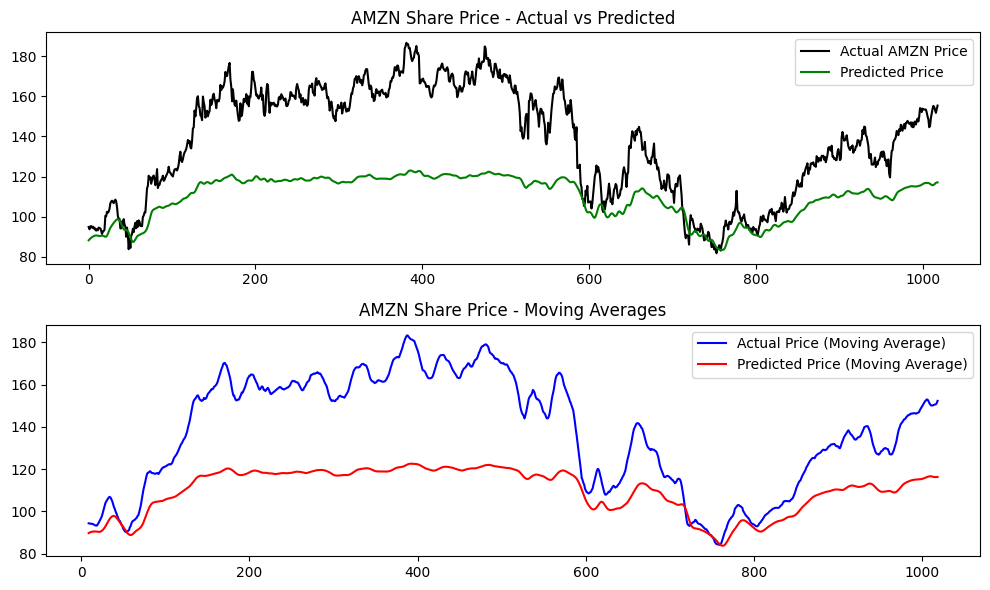

In [3]:
import keras
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf
import pandas_ta as ta
import pandas_datareader as web
import datetime as dt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from pandas_datareader import data as pdr
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt

company = "AMZN"
start = dt.datetime(2012, 1, 1)
end = dt.datetime(2020, 1, 1)

yf.pdr_override()
data = pdr.get_data_yahoo("AMZN", start = start, end = end)

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1,1))
prediction_days = 60

x_train = []
y_train = []

for x in range(prediction_days, len(scaled_data)):
    x_train.append(scaled_data[x-prediction_days:x, 0])
    y_train.append(scaled_data[x, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

model = Sequential()
model.add(LSTM(units=500, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=5))
model.add(Dropout(0.2))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, epochs=25, batch_size=32)

test_start = dt.datetime(2020, 1, 1)
test_end = dt.datetime.now()

# test_data = web.DataReader(company, 'yahoo', test_start, test_end)
# test_data = yf.download(tickers = company, start = test_start,end = test_end)
test_data = pdr.get_data_yahoo("AMZN", start = test_start, end = test_end)
actual_prices = test_data['Close'].values

total_dataset = pd.concat((data['Close'], test_data['Close']), axis=0)
model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
model_inputs = model_inputs.reshape(-1, 1)
model_inputs = scaler.transform(model_inputs)

x_test = []

for x in range(prediction_days, len(model_inputs)):
    x_test.append(model_inputs[x-prediction_days:x, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

predicted_prices = model.predict(x_test)
predicted_prices = scaler.inverse_transform(predicted_prices)

real_data = [model_inputs[len(model_inputs) + 1 - prediction_days: len(model_inputs + 1)]]
real_data = np.array(real_data)
real_data = np.reshape(real_data, (real_data.shape[0], real_data.shape[1], 1))

prediction = model.predict(real_data)
prediction = scaler.inverse_transform(prediction)
print(f"Prediction: {prediction}")

lstm_rmse = sqrt(mean_squared_error(actual_prices, predicted_prices))
print(f"Root Mean Squared Error (RMSE): {lstm_rmse}")

mae = mean_absolute_error(actual_prices, predicted_prices)
print(f"Mean Absolute Error (MAE): {mae}")

# Plot Moving Average curve
window_size = 10  # You can adjust this value based on your preference

# Calculate moving averages
actual_prices_ma = pd.Series(actual_prices).rolling(window=window_size).mean()
predicted_prices_ma = pd.Series(predicted_prices.flatten()).rolling(window=window_size).mean()

# Plot the curves
plt.figure(figsize=(10, 6))

plt.subplot(2, 1, 1)  # Subplot for actual and predicted prices
plt.plot(actual_prices, color="black", label=f"Actual {company} Price")
plt.plot(predicted_prices, color="green", label=f"Predicted Price")
plt.title(f"{company} Share Price - Actual vs Predicted")
plt.legend()

# Calculate moving averages
actual_prices_ma = pd.Series(actual_prices).rolling(window=window_size).mean()
predicted_prices_ma = pd.Series(predicted_prices.flatten()).rolling(window=window_size).mean()

# Create a new subplot for moving averages
plt.subplot(2, 1, 2)  # Subplot for moving averages
plt.plot(actual_prices_ma, color="blue", label=f"Actual Price (Moving Average)")
plt.plot(predicted_prices_ma, color="red", label=f"Predicted Price (Moving Average)")
plt.title(f"{company} Share Price - Moving Averages")
plt.legend()

plt.tight_layout()
plt.show()

[*********************100%%**********************]  1 of 1 completed


Epoch 1/25
38/38 [==============================] - 12s 39ms/step - loss: 0.0656
Epoch 2/25
38/38 [==============================] - 1s 36ms/step - loss: 0.0143
Epoch 3/25
38/38 [==============================] - 1s 37ms/step - loss: 0.0124
Epoch 4/25
38/38 [==============================] - 1s 39ms/step - loss: 0.0116
Epoch 5/25
38/38 [==============================] - 1s 39ms/step - loss: 0.0093
Epoch 6/25
38/38 [==============================] - 1s 36ms/step - loss: 0.0108
Epoch 7/25
38/38 [==============================] - 1s 37ms/step - loss: 0.0089
Epoch 8/25
38/38 [==============================] - 1s 37ms/step - loss: 0.0077
Epoch 9/25
38/38 [==============================] - 1s 37ms/step - loss: 0.0083
Epoch 10/25
38/38 [==============================] - 1s 37ms/step - loss: 0.0072
Epoch 11/25
38/38 [==============================] - 1s 37ms/step - loss: 0.0076
Epoch 12/25
38/38 [==============================] - 1s 37ms/step - loss: 0.0080
Epoch 13/25
38/38 [=================

[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 3s 3s/step
Prediction: [[142.83893]]
Root Mean Squared Error (RMSE): 11.056538765810938
Mean Absolute Error (MAE): 9.070989000434613


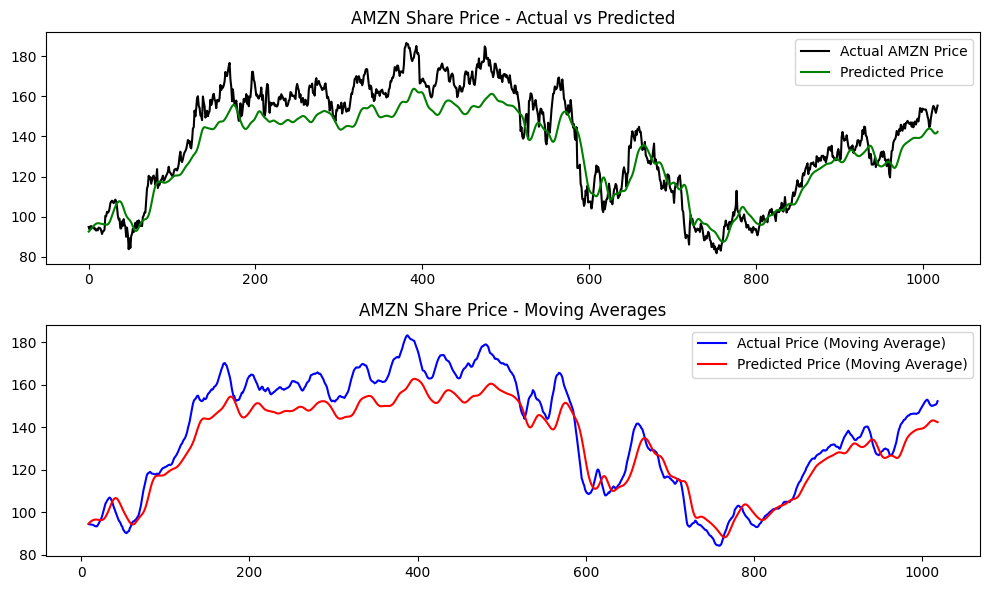

In [6]:
import keras
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf
import pandas_ta as ta
import pandas_datareader as web
import datetime as dt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from pandas_datareader import data as pdr
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt

company = "AMZN"
start = dt.datetime(2015, 1, 1)
end = dt.datetime(2020, 1, 1)

yf.pdr_override()
data = pdr.get_data_yahoo("AMZN", start = start, end = end)

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1,1))
prediction_days = 60

x_train = []
y_train = []

for x in range(prediction_days, len(scaled_data)):
    x_train.append(scaled_data[x-prediction_days:x, 0])
    y_train.append(scaled_data[x, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

model = Sequential()
model.add(LSTM(units=500, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=450, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=350, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=250, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=100, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=75))
model.add(Dropout(0.2))
model.add(Dense(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=25))
model.add(Dropout(0.2))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, epochs=25, batch_size=32)

test_start = dt.datetime(2020, 1, 1)
test_end = dt.datetime.now()

# test_data = web.DataReader(company, 'yahoo', test_start, test_end)
# test_data = yf.download(tickers = company, start = test_start,end = test_end)
test_data = pdr.get_data_yahoo("AMZN", start = test_start, end = test_end)
actual_prices = test_data['Close'].values

total_dataset = pd.concat((data['Close'], test_data['Close']), axis=0)
model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
model_inputs = model_inputs.reshape(-1, 1)
model_inputs = scaler.transform(model_inputs)

x_test = []

for x in range(prediction_days, len(model_inputs)):
    x_test.append(model_inputs[x-prediction_days:x, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

predicted_prices = model.predict(x_test)
predicted_prices = scaler.inverse_transform(predicted_prices)

real_data = [model_inputs[len(model_inputs) + 1 - prediction_days: len(model_inputs + 1)]]
real_data = np.array(real_data)
real_data = np.reshape(real_data, (real_data.shape[0], real_data.shape[1], 1))

prediction = model.predict(real_data)
prediction = scaler.inverse_transform(prediction)
print(f"Prediction: {prediction}")

lstm_rmse = sqrt(mean_squared_error(actual_prices, predicted_prices))
print(f"Root Mean Squared Error (RMSE): {lstm_rmse}")

mae = mean_absolute_error(actual_prices, predicted_prices)
print(f"Mean Absolute Error (MAE): {mae}")

# Plot Moving Average curve
window_size = 10  # You can adjust this value based on your preference

# Calculate moving averages
actual_prices_ma = pd.Series(actual_prices).rolling(window=window_size).mean()
predicted_prices_ma = pd.Series(predicted_prices.flatten()).rolling(window=window_size).mean()

# Plot the curves
plt.figure(figsize=(10, 6))

plt.subplot(2, 1, 1)  # Subplot for actual and predicted prices
plt.plot(actual_prices, color="black", label=f"Actual {company} Price")
plt.plot(predicted_prices, color="green", label=f"Predicted Price")
plt.title(f"{company} Share Price - Actual vs Predicted")
plt.legend()

# Calculate moving averages
actual_prices_ma = pd.Series(actual_prices).rolling(window=window_size).mean()
predicted_prices_ma = pd.Series(predicted_prices.flatten()).rolling(window=window_size).mean()

# Create a new subplot for moving averages
plt.subplot(2, 1, 2)  # Subplot for moving averages
plt.plot(actual_prices_ma, color="blue", label=f"Actual Price (Moving Average)")
plt.plot(predicted_prices_ma, color="red", label=f"Predicted Price (Moving Average)")
plt.title(f"{company} Share Price - Moving Averages")
plt.legend()

plt.tight_layout()
plt.show()

**Epoch=25, Larger Complexity NN**

[*********************100%%**********************]  1 of 1 completed


Epoch 1/50
38/38 [==============================] - 16s 64ms/step - loss: 0.0564
Epoch 2/50
38/38 [==============================] - 2s 61ms/step - loss: 0.0120
Epoch 3/50
38/38 [==============================] - 2s 61ms/step - loss: 0.0128
Epoch 4/50
38/38 [==============================] - 2s 64ms/step - loss: 0.0087
Epoch 5/50
38/38 [==============================] - 2s 61ms/step - loss: 0.0079
Epoch 6/50
38/38 [==============================] - 2s 61ms/step - loss: 0.0106
Epoch 7/50
38/38 [==============================] - 2s 61ms/step - loss: 0.0083
Epoch 8/50
38/38 [==============================] - 2s 61ms/step - loss: 0.0085
Epoch 9/50
38/38 [==============================] - 2s 62ms/step - loss: 0.0082
Epoch 10/50
38/38 [==============================] - 2s 63ms/step - loss: 0.0080
Epoch 11/50
38/38 [==============================] - 2s 65ms/step - loss: 0.0070
Epoch 12/50
38/38 [==============================] - 2s 62ms/step - loss: 0.0080
Epoch 13/50
38/38 [=================

[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 2s 2s/step
Prediction: [[154.94463]]
Root Mean Squared Error (RMSE): 6.242294856601391
Mean Absolute Error (MAE): 4.860328052883879


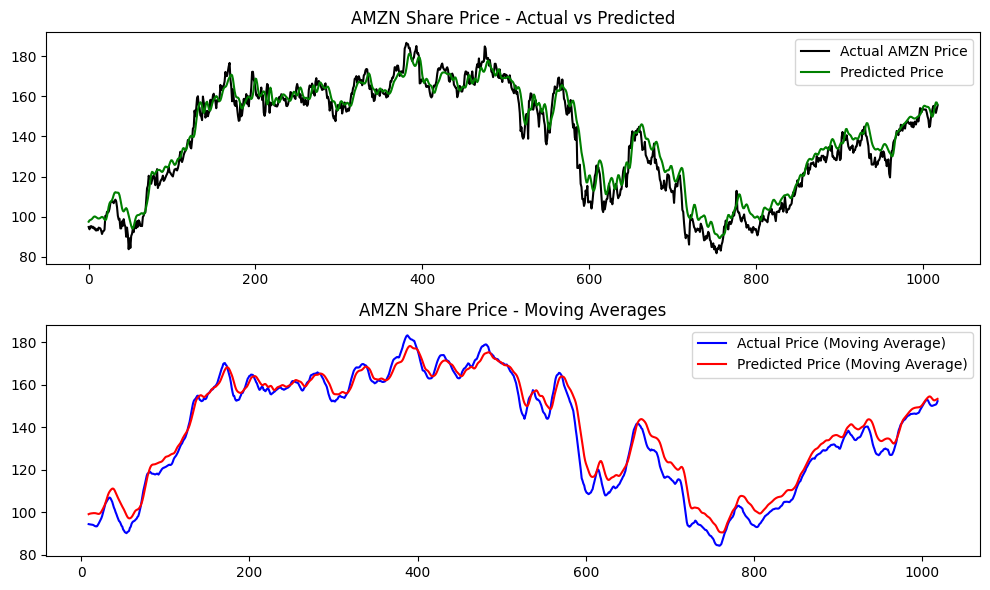

In [8]:
import keras
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf
import pandas_ta as ta
import pandas_datareader as web
import datetime as dt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from pandas_datareader import data as pdr
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt

company = "AMZN"
start = dt.datetime(2015, 1, 1)
end = dt.datetime(2020, 1, 1)

yf.pdr_override()
data = pdr.get_data_yahoo("AMZN", start = start, end = end)

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1,1))
prediction_days = 60

x_train = []
y_train = []

for x in range(prediction_days, len(scaled_data)):
    x_train.append(scaled_data[x-prediction_days:x, 0])
    y_train.append(scaled_data[x, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

model = Sequential()
model.add(LSTM(units=1198, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=500, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=350, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=250, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=100, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=75))
model.add(Dropout(0.2))
model.add(Dense(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=25))
model.add(Dropout(0.2))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, epochs=50, batch_size=32)

test_start = dt.datetime(2020, 1, 1)
test_end = dt.datetime.now()

# test_data = web.DataReader(company, 'yahoo', test_start, test_end)
# test_data = yf.download(tickers = company, start = test_start,end = test_end)
test_data = pdr.get_data_yahoo("AMZN", start = test_start, end = test_end)
actual_prices = test_data['Close'].values

total_dataset = pd.concat((data['Close'], test_data['Close']), axis=0)
model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
model_inputs = model_inputs.reshape(-1, 1)
model_inputs = scaler.transform(model_inputs)

x_test = []

for x in range(prediction_days, len(model_inputs)):
    x_test.append(model_inputs[x-prediction_days:x, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

predicted_prices = model.predict(x_test)
predicted_prices = scaler.inverse_transform(predicted_prices)

real_data = [model_inputs[len(model_inputs) + 1 - prediction_days: len(model_inputs + 1)]]
real_data = np.array(real_data)
real_data = np.reshape(real_data, (real_data.shape[0], real_data.shape[1], 1))

prediction = model.predict(real_data)
prediction = scaler.inverse_transform(prediction)
print(f"Prediction: {prediction}")

lstm_rmse = sqrt(mean_squared_error(actual_prices, predicted_prices))
print(f"Root Mean Squared Error (RMSE): {lstm_rmse}")

mae = mean_absolute_error(actual_prices, predicted_prices)
print(f"Mean Absolute Error (MAE): {mae}")

# Plot Moving Average curve
window_size = 10  # You can adjust this value based on your preference

# Calculate moving averages
actual_prices_ma = pd.Series(actual_prices).rolling(window=window_size).mean()
predicted_prices_ma = pd.Series(predicted_prices.flatten()).rolling(window=window_size).mean()

# Plot the curves
plt.figure(figsize=(10, 6))

plt.subplot(2, 1, 1)  # Subplot for actual and predicted prices
plt.plot(actual_prices, color="black", label=f"Actual {company} Price")
plt.plot(predicted_prices, color="green", label=f"Predicted Price")
plt.title(f"{company} Share Price - Actual vs Predicted")
plt.legend()

# Calculate moving averages
actual_prices_ma = pd.Series(actual_prices).rolling(window=window_size).mean()
predicted_prices_ma = pd.Series(predicted_prices.flatten()).rolling(window=window_size).mean()

# Create a new subplot for moving averages
plt.subplot(2, 1, 2)  # Subplot for moving averages
plt.plot(actual_prices_ma, color="blue", label=f"Actual Price (Moving Average)")
plt.plot(predicted_prices_ma, color="red", label=f"Predicted Price (Moving Average)")
plt.title(f"{company} Share Price - Moving Averages")
plt.legend()

plt.tight_layout()
plt.show()